In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue

c:\Users\dimaf\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")
len(dataset)

100%|██████████| 18/18 [00:03<00:00,  5.88it/s]


18

In [3]:
train_problem = dataset[0]
test_problem = dataset[2]
train_problem["name"], test_problem["name"]

('5,10,10-1', '5,10,10-3')

In [4]:
delta, train_gamma, status, value = mip_solve(train_problem)
print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-1: 5086.08, OptimizationStatus.OPTIMAL


In [5]:
delta, test_gamma, status, value = mip_solve(test_problem)
print(f'Problem {test_problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-3: 7652.32, OptimizationStatus.FEASIBLE


In [6]:
train_graph = dglgraph(train_problem, train_gamma)
train_target = train_graph.edata["target"][os_type]
train_graph.edata["feat"][os_type][:, 0] /= 10
train_graph.edata["feat"][ss_type][:] /= 100

test_graph = dglgraph(test_problem, test_gamma)
test_target = test_graph.edata["target"][os_type]
test_graph.edata["feat"][os_type][:, 0] /= 10
test_graph.edata["feat"][ss_type][:] /= 100

In [7]:
model = GNN(1, train_problem["n_operations"] + 2, 16, 1)

In [8]:
train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

In [9]:
optim = Adam(model.parameters(), lr=0.001)

for i in trange(1000):
    logits = model(train_graph)
    loss = F.binary_cross_entropy_with_logits(logits, train_target)
    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 10 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma = model.pred(train_graph, train_problem)
            train_objvalue.append(
                objvalue(
                    train_problem,
                    pred_gamma,
                    construct_delta(train_problem, pred_gamma),
                )
            )
            logits = model(test_graph)
            loss = F.binary_cross_entropy_with_logits(logits, test_target)
            test_loss.append(loss.item())
            pred_gamma = model.pred(test_graph, test_problem)
            test_objvalue.append(
                objvalue(
                    test_problem, pred_gamma, construct_delta(test_problem, pred_gamma)
                )
            )

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'GNN' object has no attribute 'pred'

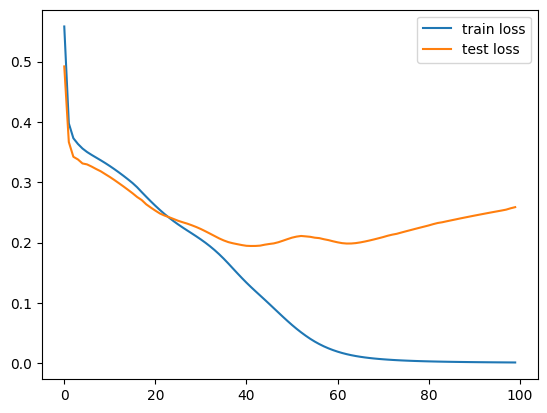

In [ ]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

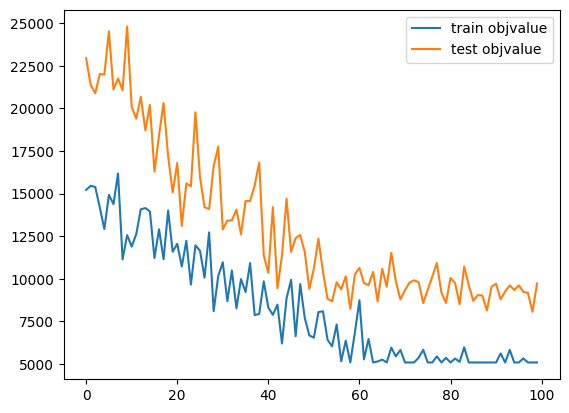

In [ ]:
plt.plot(train_objvalue, label="train objvalue")
plt.plot(test_objvalue, label="test objvalue")
plt.legend()
plt.show()

In [ ]:
min(test_objvalue)

8058.129105766255